In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../..')) 


In [2]:

from recidiviz.calculator.modeling.population_projection.simulations.super_simulation_factory import SuperSimulationFactory
from recidiviz.calculator.modeling.population_projection.simulations.compartment_transitions import CompartmentTransitions
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
import pandas as pd
from functools import partial
import yaml

pd.options.display.max_rows = 200

In [3]:
test_sim = SuperSimulationFactory.build_super_simulation('../state/AZ/financial_incentives/AZ_supervision_model_inputs.yaml')
# commented this out once I'm working on the policy but this should be the first thing you run to make sure the simulation is functional
# test_sim.simulate_baseline(['probation', 'parole'])

/Users/pacopoler/.local/share/virtualenvs/pulse-data-Jd9N3JcA/lib/python3.7/site-packages/google/cloud/bigquery/table.py:1770: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  create_bqstorage_client=create_bqstorage_client,


outflows_data returned 288 results
transitions_data returned 51 results
total_population_data returned 144 results


initialization time:  25.77576208114624
simulation_time:  21.070502042770386
initialization time:  28.310911893844604
simulation_time:  20.45291805267334


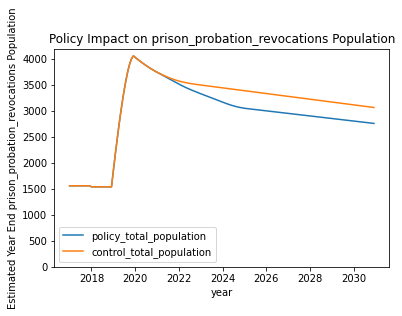

In [8]:
# Policy Option Methods
revocation_outflows = {
    'parole': 'prison_parole_revocations',
    'probation': 'prison_probation_revocations',
}
REVOCATION_REDUCTION = 0.1

def incentivize_completions(reduction, compartment, retroactive=False):
    return partial(CompartmentTransitions.reallocate_outflow, 
                   reallocation_df=pd.DataFrame({
                       'outflow':[revocation_outflows[compartment]],
                       'affected_fraction': [reduction],
                       'new_outflow': ['release']
                   }),
                   reallocation_type='*',
                   retroactive=retroactive)


policy_list_non_retroactive = [
    SparkPolicy(policy_fn=incentivize_completions(REVOCATION_REDUCTION, compartment),
                spark_compartment=compartment,
                sub_population={'crime': 'x'},
                apply_retroactive=False)
    for compartment in revocation_outflows
]
    
test_results = test_sim.simulate_policy(policy_list_non_retroactive, 'prison_probation_revocations')

In [9]:
simulation_tag = 'AZ_PO_incentives_10%'
test_sim.upload_simulation_results_to_bq('recidiviz-staging', simulation_tag)